#Identifying Fraund from Enron Email

<em><small>Uirá Caiado. June 21, 2015</small></em>

----------

###Abstract

I explore the public Enron financial and email dataset to identify Enron Employees who may have committed fraud. My goal is to build a machine learning algorithm to solve this chalange.

###Introduction

According to <a href="https://en.wikipedia.org/wiki/Enron">Wikipedia</a>, Enron was an energy, commodities, and services company that had employed approximately 20,000 staff. It was one of the largest companies in the United States, with claimed revenues of nearly $111 billion during 2000.

Also, it was one of the largest business scandals in American history, falling into bankruptcy in 2001 after was revealed widespread corporate fraud. As pointed out in the Udacity <a href="https://docs.google.com/document/d/10GYepNkDj-Kc_Sf6to3WX_q_SdymPOBJf3H-pq7a62g/pub">project description</a>, in the resulting Federal investigation, there was a significant amount of typically confidential information entered into the public record, including emails and financial data for top executives.

Given that there is a list of people who were somewhat involved in the scandal, here called person of interest (POI), I will try to develop a machine learning algorithm to identify those people with an acceptable accuracy.

###Understanding the Dataset

#####Data Exploration

The data set is relatively small, and the number of identified POIs is even smaller. There are 146 different data points, or people, in this collection, but just 18 were classified as POIs. Each data point has 21 features, although more than half of these features didn't display any information for 40% or more of all dataset, as shown below.

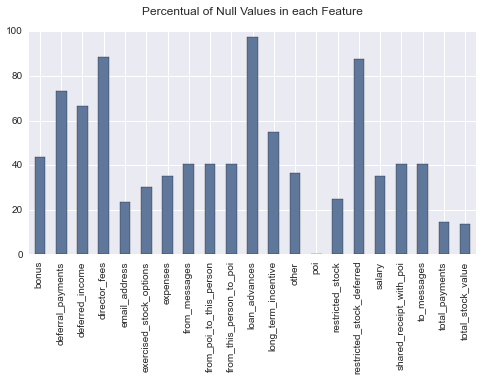

In [30]:
o_stats.NanAtFetaures(o_enron);

Related to the features, I can categorize them into four groups:
- *Metadata*: 2 in total. If it is POI and email address. POI is what I want to predicted
- *Payments*: 10 in total. One is the summation and others are Salary, Bonus...
- *Stock Value*: 4 in total. One is also summation. for instance, Restricted stock options, Excercise stock options...
- *Emails*: 5 in total. Examples are "from POI to this person", "from messages"...

According to the documentary [The smartest guys in the room](https://www.youtube.com/watch?v=pRWXW87YrlM), the executives involved in the scandal used to exercise their option positions early. Later I will check if it can be a useful to identify POIs. Also, I don´t know if I will use the summations in Payments and Stock Value features. Maybe to look for outliers or to build new features. Excluding the both features, the POI features (that is the target) and the email address, it leaves me with 18 features to use.

Despite all the missing data, it still would be complex to analyze all possible correlations between these features. Here is where machine learning (ML) comes to play. Quonting this [book](http://www.amazon.com/Building-Machine-Learning-Systems-Python/dp/1782161406), ML teaches machines how to carry out tasks by themselves, providing them with a couple of examples.

#####Outlier Investigation

The point here is those examples mentioned. They should be VALID examples if I want to build a good estimator or classifier. Then, first of all, I need to look for outliers. Let's check it by looking some of the features.

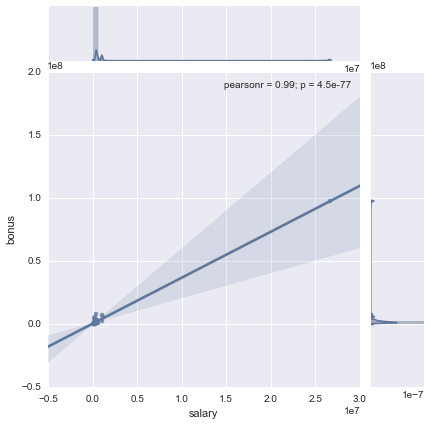

In [32]:
o_stats.scatter("salary", "bonus", o_enron)

Here can be easily visualized that there is some data far away from the most of the data points. First, I am going to check who is in the top 10% of the "salary" feature.


In [33]:
o_stats.getDecile('salary', o_enron)

,salary,poi
TOTAL,26704229,False


Hm... a summation. I will exclude this data point and run the scatter plot again 

In [45]:
o_enron.excludeOutliers(l_outliers =  ["TOTAL"])

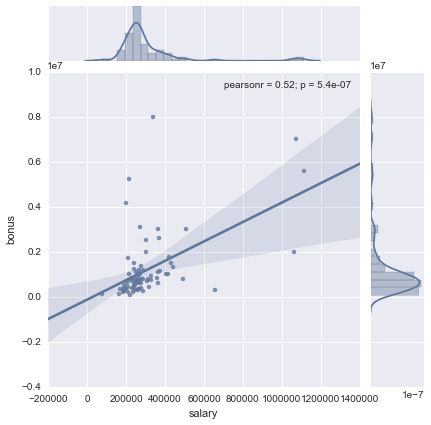

In [35]:
o_stats.scatter("salary", "bonus", o_enron)

Much better. Looking at the last decile of each feature, I can see that neither salary or bonus seems hold real outliers. Curiously, the biggest bonus wasn't to a POI.

In [36]:
o_stats.getDecile('salary', o_enron)

,salary,poi
SKILLING JEFFREY K,1111258,True


In [37]:
o_stats.getDecile('bonus', o_enron)

,bonus,poi
LAVORATO JOHN J,8000000,False


Well... Let's look if there is another outlier. First, I will use the summations to check other features. Any difference between the values I will show in a line called "Delta".

In [38]:
df1, df2 = stats.checkSummation(o_enron)
#checking Stocks feature
df1

,BELFER ROBERT
poi,0
restricted_stock,0
restricted_stock_deferred,44093
exercised_stock_options,3285
total_stock_value,-44093
Delta,91471


In [39]:
#checking Payments features
df2

,BELFER ROBERT,BHATNAGAR SANJAY
poi,0,0
bonus,0,0
deferral_payments,-102500,0
deferred_income,0,0
director_fees,3285,137864
expenses,0,0
loan_advances,0,0
long_term_incentive,0,0
other,0,137864
salary,0,0


Looking at the enron61702 pdf file, I can see that the differences above are due to some missing information. As it can bias the algorithms and both are non-POIs, I am going to exclude them.

In [46]:
o_enron.excludeOutliers(l_outliers =  ["BELFER ROBERT","BHATNAGAR SANJAY"])

Ok, now I am going to input zeros in all "Nan" values in the data set, and then I will remove any data point that won't help  (all features are equal to zero). Finally, I will show a description of all numeric data to see if there is any evidence of another outlier.

In [47]:
o_enron.fill_and_remove()
o_stats.describe(o_enron)

,count,mean,std,min,25%,50%,75%,max
bonus,142.00,"685,518","1,239,221",0,0,"300,000","800,000","8,000,000"
deferral_payments,142.00,"225,939","758,698",0,0,0,"9,684","6,426,990"
deferred_income,142.00,"-196,411","609,852","-3,504,386","-37,926",0,0,0
director_fees,142.00,"9,127","29,607",0,0,0,0,"125,034"
exercised_stock_options,142.00,"2,086,674","4,826,031",0,0,"608,294","1,660,454","34,348,384"
expenses,142.00,"35,874","45,432",0,0,"21,937","53,741","228,763"
from_messages,142.00,368,"1,460",0,0,18,55,"14,368"
from_poi_to_this_person,142.00,39,75,0,0,6,42,528
from_this_person_to_poi,142.00,25,80,0,0,0,14,609
loan_advances,142.00,"591,021","6,842,133",0,0,0,0,"81,525,000"


Although there are pretty big numbers in the financial information, they are all related to executives from Eron. Now, I have 142 data points left and I believe that I am done here. 

###Feature Selection and Engineering
#####Creating and Scaling Features

There are two points that caught my attention in the documentary "The Smartest Guys in The Room". First, some of the top executives used to spend a lot of the firm's money in strip clubs. Second, there were some employees who exercised much of their stock options earlier, knowing about the company's financial conditions. Based on these facts, I will include two more features to be tested:
- Scaled Expenses: I can't compare to another Payment features from the data points because the amount of money they had made with salary or bonus might diminish the importance of this features. Then, I will scale this feature using its own maximum and minimun value.
- Exercised Stock Option vs. Total of Payment: If a high stake of your money is in a company that you know that is going to crash, what would you do? Sell, sell as much as you can. I will divide the total of stock options that were exercised by the total of money each one has made (I will not consider the remain stock options). I want to know if the amount of options of each POIs were relevant to their saving accounts. I will scale this feature.

Below I am going to draw the box plot of each new feature. I will exclude some outliers just to these visualizations.

In [58]:
#exclude it from the final version
import eda_new; reload(eda_new);
import dataset; reload(dataset);
import featureSelection; reload(featureSelection);

o_enron = dataset.LoadEnron()
o_stats = eda_new.Eda()
o_features = featureSelection.Features()
o_enron.excludeOutliers(l_outliers =  ["BELFER ROBERT","BHATNAGAR SANJAY", "TOTAL"])
o_enron.fill_and_remove()

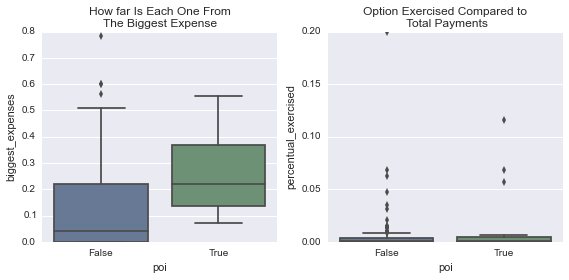

In [59]:
o_features.createNewFeatures(o_enron)
o_stats.compareFeaturesCreated(o_enron)

The Biggest Expenses feature is more dispersed when related to POIs. The second feature, the Option excercised compared to the total payment of each data point, doesn't seem much relevant. I will test both in the feature selection step. 

Lastly, as I intend to use the K-means algorithm as one of my machine-learning candidates, I will use scaled and non-scaled features in my tests. I have to scale the data because K-means uses the distance between the data points as a measure of similarity between them.

Considering that there are two different units in the features to be tested, money and count of e-mails, I am going to scale each group of features separately, but all features of the same group together.

In [60]:
o_features.scallingAll(o_enron)
o_enron.df_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
bonus,142,0.049276,0.014574,0.041214,0.041214,0.044742,0.050622,0.135299
deferral_payments,142,0.043871,0.008923,0.041214,0.041214,0.041214,0.041328,0.116799
deferred_income,142,0.038904,0.007172,0.000000,0.040768,0.041214,0.041214,0.041214
director_fees,142,0.041321,0.000348,0.041214,0.041214,0.041214,0.041214,0.042684
exercised_stock_options,142,0.065754,0.056757,0.041214,0.041214,0.048368,0.060742,0.445173
expenses,142,0.041636,0.000534,0.041214,0.041214,0.041472,0.041846,0.043904
from_messages,142,0.024325,0.096398,0.000000,0.000000,0.001155,0.003631,0.948445
from_poi_to_this_person,142,0.002594,0.004928,0.000000,0.000000,0.000363,0.002756,0.034854
from_this_person_to_poi,142,0.001648,0.005300,0.000000,0.000000,0.000000,0.000924,0.040201
loan_advances,142,0.048165,0.080468,0.041214,0.041214,0.041214,0.041214,1.000000


As I can see, there are plenty of $0.041214$ in the scaled data set. It is the equivalent of $0$ in the non-scale data.

#####Selecting the best ones

In [65]:
#exclude it from the final version
import eda_new; reload(eda_new);
import dataset; reload(dataset);
import featureSelection; reload(featureSelection);

o_enron = dataset.LoadEnron()
o_stats = eda_new.Eda()
o_features = featureSelection.Features()
o_enron.excludeOutliers(l_outliers =  ["BELFER ROBERT","BHATNAGAR SANJAY", "TOTAL"])
o_enron.fill_and_remove()
o_features.createNewFeatures(o_enron)
o_features.scallingAll(o_enron)


Now, what features should I use to train my machine learning algorithms? As I discussed before, there are some features that most of the values is equal to "Nan". As I want to examine all features related to emails behaviour, I will cut all those that have presented less than 45% of valid numbers. Below, I presented the $10$ smallest ValidNumber ratios.

In [62]:
o_stats.notValidNumbersTable(o_enron).tail(10)

,ValidNumbers
bonus,0.570423
from_poi_to_this_person,0.521127
from_this_person_to_poi,0.457746
long_term_incentive,0.457746
deferred_income,0.338028
deferral_payments,0.260563
poi,0.126761
restricted_stock_deferred,0.105634
director_fees,0.098592
loan_advances,0.021127


I am going to select features according to the 20th percentile of the highest scores. I am using ANOVA F-test function to score all features.

In [74]:
features_list = o_features.getFeaturesList(o_enron, o_stats,f_validNumMin=0.45)
labels, features= o_features.getFeaturesAndLabels(o_enron, o_stats,f_validNumMin = 0.45)
labels_scaled, features_scaled  = o_features.getFeaturesAndLabels(o_enron, o_stats,scaled=True, f_validNumMin = 0.45)

In [75]:
l_selectedFetures, df_rtn = o_features.select(features, labels, features_list)
"features selected: {}".format(l_selectedFetures)

"features selected: ['bonus', 'salary', 'exercised_stock_options']"

Just Payment and Stock Value features. No Email or New features. Looking at p-value ranking of the features, I see that the best-ranked Email feature was shared receipt with poi. I will keep it as one of my features selected for futures tests. 

In [76]:
df_rtn

,pValue_Max
exercised_stock_options,1.000000
bonus,0.857466
salary,0.769350
long_term_incentive,0.466340
percentual_exercised,0.444304
restricted_stock,0.436342
shared_receipt_with_poi,0.416612
expenses,0.314408
biggest_expenses,0.314408
from_poi_to_this_person,0.280534


Ow...one last thing. As I will use just some features in the next section, I am going to remove any data point that __all the selected features__ are equal to $0$. 

In [77]:
o_enron.fill_and_remove(l_features= l_selectedFetures)

Now, I just have $122$ data points. 

###Pick and Tune an Algorithm

In [3]:
#exclude it from the final version
#exclude it from the final version
import eda_new; reload(eda_new);
import dataset; reload(dataset);
import featureSelection; reload(featureSelection);

o_enron = dataset.LoadEnron()
o_stats = eda_new.Eda()
o_features = featureSelection.Features()
o_enron.excludeOutliers(l_outliers =  ["BELFER ROBERT","BHATNAGAR SANJAY", "TOTAL"])
o_enron.fill_and_remove()
o_features.createNewFeatures(o_enron)
o_features.scallingAll(o_enron)

features_list = o_features.getFeaturesList(o_enron, o_stats,f_validNumMin=0.45)
labels, features= o_features.getFeaturesAndLabels(o_enron, o_stats,f_validNumMin = 0.45)
l_selectedFetures, df_rtn = o_features.select(features, labels, features_list)
o_enron.fill_and_remove(l_features= l_selectedFetures)
#selecgtinn everything again
labels, features= o_features.getFeaturesAndLabels(o_enron, o_stats,f_validNumMin = 0.45, l_columns = l_selectedFetures)
labels_scaled, features_scaled  = o_features.getFeaturesAndLabels(o_enron, o_stats,scaled=True, f_validNumMin = 0.45, l_columns = l_selectedFetures)

#####Selecting an Algorithm
- At least 2 different algorithms attempted, and their performance is compared with the more performant one used in the final analysis
- What algorithm did you end up using?
- What other one(s) did you try?
- [relevant rubric item: “pick an algorithm”]

#####Tuning the classifiers
- What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well? 
- How did you tune the parameters of your particular algorithm?  (Some algorithms don’t have parameters that you need to tune--if this is the case for the one you picked, identify and briefly explain how you would have done it if you used, say, a decision tree classifier).
- [relevant rubric item: “tune the algorithm”]
- Response addresses what it means to perform parameter tuning and why it is important.
- At least one important parameter tuned, with at least 3 settings investigated; or any of the following are true:
- GridCV used for parameter tuning
- Several parameters tuned
- Parameter tuning incorporated into algorithm selection (i.e. parameters tuned for more than one algorithm, and best algorithm-tune combination selected for final analysis)

#####What about the features created

- the effect of features created on the final algorithm performance is tested.

In [25]:
import eda_new; reload(eda_new);
import dataset; reload(dataset);
import featureSelection; reload(featureSelection);

o_enron = dataset.LoadEnron()
o_stats = eda_new.Eda()
o_features = featureSelection.Features()
o_enron.excludeOutliers(l_outliers =  ["BELFER ROBERT","BHATNAGAR SANJAY", "TOTAL"])
o_enron.fill_and_remove(b_remove = False)
o_features.createNewFeatures(o_enron)
o_features.scallingAll(o_enron)

In [31]:
d_test = my_dataset[key]

In [37]:
my_dataset[key][new_feature] = f_aux

In [55]:
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(min_samples_split=50))
clf.fit(features_train, labels_train)
predictions = clf.predict(features_test)

In [57]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV

In [161]:
#testando um adaboost com PCA
estimators = [('reduce_dim', PCA()),
              ('AdaBoost', AdaBoostClassifier())]
clf = Pipeline(estimators);
# clf.set_params(AdaBoost__base_estimator=DecisionTreeClassifier(min_samples_split=50));

In [ ]:
max_features, max_depth 

In [95]:
import classifiers; reload(classifiers);

In [39]:
o_clf = classifiers.Classifier("AdaBoost")
self = o_clf

In [ ]:
o_clf = classifiers.Classifier("KNeighbors")
self = o_clf

In [65]:
o_clf = classifiers.Classifier("SVM")
self = o_clf

In [82]:
o_clf = classifiers.Classifier("DecisionTree")
self = o_clf

In [85]:
o_clf = classifiers.Classifier("GaussianNB")
self = o_clf

In [96]:
o_clf = classifiers.Classifier("RandomForest")
self = o_clf

In [68]:
DecisionTreeClassifier?

In [ ]:
n_estimators, max_features, max_depth 

In [70]:
RandomForestClassifier?

In [90]:
o_clf.crossValidation(features_scaled, labels_scaled)


Classifier Used
------------------
Pipeline(steps=[('reduce_dim', PCA(copy=True, n_components=None, whiten=False)), ('RandomForest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

Classification Report
------------------
Accuracy: 0.85831	Precision: 0.57948	Recall: 0.28800	F1: 0.38477	F2: 0.32021

Confusion Matrix
------------------
Total predictions: 13000	True positives:  576	False positives:  418
				False negatives: 1424	True negatives: 10582




In [97]:
o_clf.gridSearch(features_scaled, labels_scaled)

Best Score: 0.8607

PARAMETERS TESTED
------------------

{'RandomForest__max_depth': [3, 10, 50],
 'RandomForest__n_estimators': [10, 20, 50, 100],
 'reduce_dim__n_components': [1, 2, 3]}

BEST PARAMETER
------------------

{'RandomForest__max_depth': 3,
 'RandomForest__n_estimators': 100,
 'reduce_dim__n_components': 2}


In [98]:
o_clf.crossValidation(features_scaled, labels_scaled)

!!!!ALREADY TUNNED

Classifier Used
------------------
Pipeline(steps=[('reduce_dim', PCA(copy=True, n_components=2, whiten=False)), ('RandomForest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

Classification Report
------------------
Accuracy: 0.87462	Precision: 0.70928	Recall: 0.31350	F1: 0.43481	F2: 0.35288

Confusion Matrix
------------------
Total predictions: 13000	True positives:  627	False positives:  257
				False negatives: 1373	True negatives: 10743




In [107]:
o_clf.clf.steps[1][1].feature_importances_ 

array([ 0.5236133,  0.4763867])

In [108]:
clf = o_clf.clf.steps[1][1]

###Validate and Evaluate

#####Usage of Evaluation Metrics

- What is validation, and what’s a classic mistake you can make if you do it wrong?
- Response addresses what validation is and why it is important.
- The data is split into training and testing sets, with the testing data used for assessing overall analysis performance; or k-fold cross validation is deployed

#####Validation Strategy

- How did you validate your analysis?
- [relevant rubric item: “validation strategy”]

#####Algorithm Performance

- Give at least 2 evaluation metrics, and your average performance for each of them.
- Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance
- [relevant rubric item: “usage of evaluation metrics”]
- Precision and recall are used to evaluate algorithm performance, and student articulates what those metrics measure.


###Reflection

- As I reproduce much of Udacity code, and end up find that a wrong selection can be lead to a tottaly different result

####TODO:
<p>7/10/2015 - Create a table with all APR of the algos tested. Show the complete report just for the algo choose</p>
<p>7/6/2015 - If you used an algorithm like a decision tree, please also give the feature importances of the features that you use.</p>

<hr>
<em>
<p>7/9/2015 - Insert time to run the ML algos</p>
<p>6/27/2015 - Keep the statistic summary as attribute and include the features selected and the bigger p_value ratio as new columns. Use it to present the results, sorted by p_values. From stats, show just count and the mean to justify the scaling</p>
<p>7/5/2015 - What features did you end up using in your POI identifier, and what selection process did you use to pick them?  </p>
<p>7/4/2015 - Did you have to do any scaling? Why or why not?</p>
<p>6/30/2015 - Add a ratio of exercise stock options and total stock options. Justify by the movie. Maybe show a chart to answer why try it</p>
<p>7/3/2015 - As part of the assignment, you should attempt to engineer your own feature that doesn’t come ready-made in the dataset--explain what feature you tried to make, and the rationale behind it.  (You do not necessarily have to use it in the final analysis, only engineer and test it.) </p>
<p>6/27/2015 - Compare the summation of Payment and Stocks Features to see if all if correctly filled</p>
<p>6/26/2015 - probably is someone important....I could plot a heat map with all datapointsand from to_poi features, splitting it between POIs and non-POIS...in another section - will be not necessary</p>
</em>

<em>Custom CSS</em>

In [84]:
#loading style sheet
from IPython.core.display import HTML
HTML( open('ipython_style.css').read() )

In [2]:
#changing matplotlib defaults
import eda; reload(eda);
stats = eda.Eda()
%matplotlib inline
import seaborn as sns
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})
sns.set_style("darkgrid")

In [42]:
import eda_new; reload(eda_new);
import dataset; reload(dataset);
o_enron = dataset.LoadEnron()
o_stats = eda_new.Eda()